## Análise de Resultados

In [1]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/marlesson/Backup/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors, confidence
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st

#sys.path.insert(0, os.path.dirname(__file__))


In [2]:
models_and_legend = {
  "____random_":           ["bandit_policy", "observation"],
  "____fixed_":            ["bandit_policy", "observation"],
  "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____model_":            ["bandit_policy","full_refit", "val_split_type"],
  "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
  "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
  "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
  "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
  "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
  "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
}

path = PATH_EVAL_REINFORCEMENT

In [20]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
result_paths

['/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_db4a4ecb2f',
 '/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_baba554b6d',
 '/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_20504107e4',
 '/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_caa0264656',
 '/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c

## Filter Data

In [6]:
#city = "Rio de Janeiro, Brazil"
#city = "Como, Italy"
#city = "Chicago, USA"
city = "New York, USA"
city = 'Copenhagen, Denmark'

df_params = load_iteractions_params(result_paths)
df_params = df_params[df_params['data_frames_preparation_extra_params.filter_city'] == city]
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,activation_function,balance_fields,bandit_policy,bandit_policy_params.alpha,bandit_policy_params.arg,bandit_policy_params.decay_rate,bandit_policy_params.epsilon,bandit_policy_params.exploration_threshold,bandit_policy_params.explore_rounds,bandit_policy_params.logit_multiplier,...,sampling_strategy,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,none,3,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,none,9,0.1,0,0.0,time,False,0.2,random,lecun_normal


In [7]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits

,bandit_policy,observation,iteraction,name,model
0,adaptive,,"[/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_06f94b981b, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_568f5e9270, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_8dfae0946d, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_7158a4c619, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_3ad275189d, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_5e3cd93406, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_e8783d33a2, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_a0da7386ce, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_9da6ad4afd, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_294734ecdd]",adaptive,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_a0da7386ce
1,custom_lin_ucb,,"[/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_c2d4e19069, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_8b88621aed, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_3f29862bf9, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_876309462c, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_94e27aa715, /media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhage

## Geral

In [8]:
reward_metrics = []

In [9]:
for i, row in list_bandits.iterrows():
    df_metrics = get_metrics_reward(row['iteraction'])
    df_metrics['bandit'] = row['name']
    df_metrics['model']  = row['model']

    df_g_metrics = group_metrics(df_metrics)
    reward_metrics.append(df_g_metrics)

In [10]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
softmax_explorer,0.308253,0.003106,6499.2,65.484180,10,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_1cfde5a6ab
random,0.041453,NaN,874.0,NaN,1,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_db4a4ecb2f
percentile_adaptive,0.283476,0.004021,5976.8,84.775258,10,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____percentile_adapt_840d459ee2
model,0.335591,0.008844,7075.6,186.458336,10,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____model_1ec8afd89b
lin_ucb,0.093441,0.004329,1970.1,91.268164,10,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_bada533c47
lin_ts,0.059619,NaN,1257.0,NaN,1,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ts_9cdf5ca6e8
fixed Popular Item,0.106574,NaN,2247.0,NaN,1,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_20504107e4
fixed First Item,0.260956,NaN,5502.0,NaN,1,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_baba554b6d
explore_then_exploit,0.259182,0.003143,5464.6,66.269148,10,/media/marlesson/8ba238ab-96c3-466c-99d1-a1e8385c9c46/results-copenhagen-denmark-crm/results-copenhagen-denmark-crm/output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_e3787a6d83


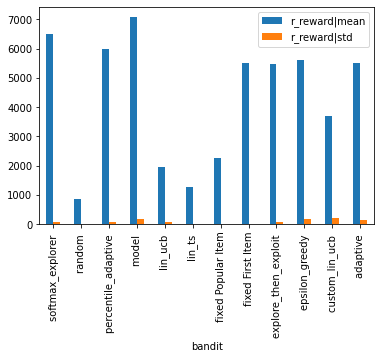

In [11]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [12]:
df_all.to_csv("output/tmp/stats.csv")

## Plot

In [13]:

removed           = df_all.loc[['model ', 'fixed First Item']]['model|first'].values

input_legend      = ['bandit_policy', 'observation']
input_iteraction  = [p.split("/")[-1] for p in df_all['model|first'] if p not in removed]
sample_size       = 100000
window_size       = 1000 

st.set_option("client.displayEnabled", False)

metrics           = load_all_iteraction_metrics(input_iteraction, sample_size)
params            = load_iteractions_params2(input_iteraction)

df_metrics_reward = metrics.groupby("iteraction").agg({'reward': ['mean', 'sum']}).reset_index().sort_values([('reward', 'sum')], ascending=False)

df  = metrics.merge(params, on=['iteraction'], how='left')\
            .merge(metrics.groupby("iteraction")\
                    .agg({'reward': 'mean'})\
                    .rename(columns={'reward': 'sum_reward'})\
                    .reset_index(), 
              on=['iteraction'], how='left')\
            .reset_index()\
            .sort_values(['sum_reward', 'idx'], ascending=[False, True])


df.to_pickle('output/tmp/iteraction_df.pkl')
df.head()

/media/marlesson/Backup/workspace/DeepFood/deep-reco-gym/tools/eval_viz/app.py:161: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,index,user,item,reward,index_env,idx,iteraction,activation_function,balance_fields,bandit_policy,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init,sum_reward
0,0,1039,94,0.0,18,0,TrivagoLogisticModelInteraction_selu____softmax_explorer_1cfde5a6ab,selu,[],softmax_explorer,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.309619
1,1,1206,175,0.0,44,1,TrivagoLogisticModelInteraction_selu____softmax_explorer_1cfde5a6ab,selu,[],softmax_explorer,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.309619
2,2,959,114,0.0,69,2,TrivagoLogisticModelInteraction_selu____softmax_explorer_1cfde5a6ab,selu,[],softmax_explorer,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.309619
3,3,1203,63,0.0,89,3,TrivagoLogisticModelInteraction_selu____softmax_explorer_1cfde5a6ab,selu,[],softmax_explorer,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.309619
4,4,204,13,1.0,117,4,TrivagoLogisticModelInteraction_selu____softmax_explorer_1cfde5a6ab,selu,[],softmax_explorer,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.309619


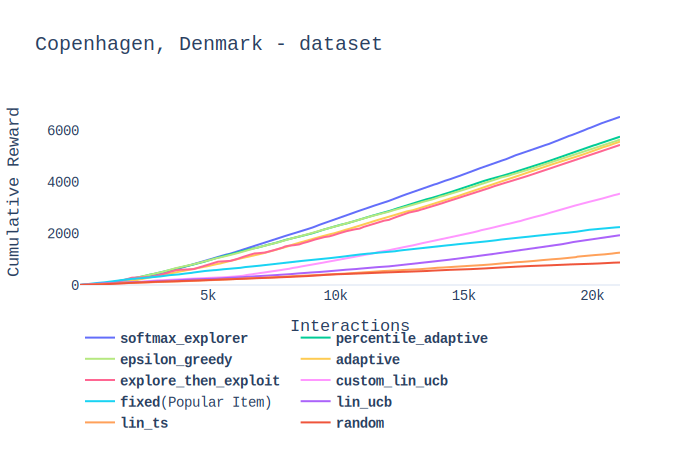

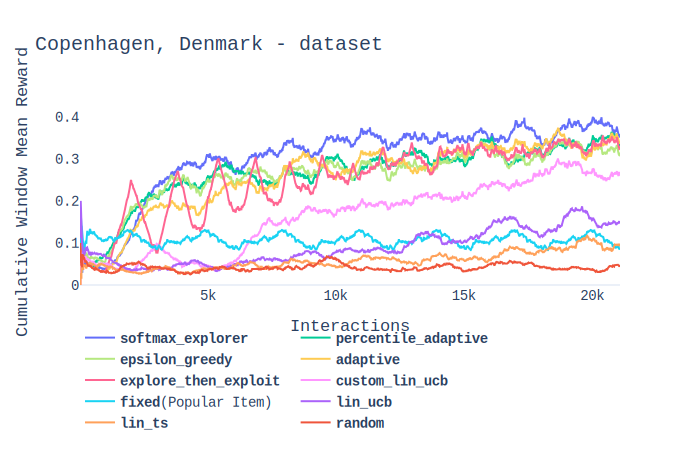

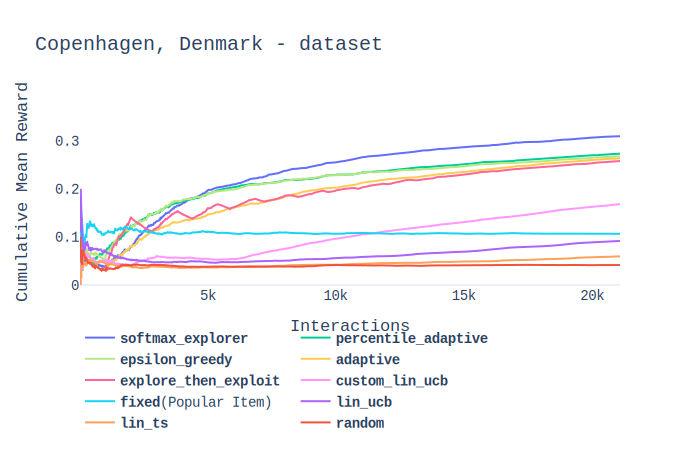

In [14]:
df = pd.read_pickle('output/tmp/iteraction_df.pkl')

# GERAL
for input_metrics in ['Cumulative Reward', 'Cumulative Window Mean Reward', 'Cumulative Mean Reward']:
    #input_metrics = 'Cumulative Mean Reward'
    fig = plot_line_iteraction(df, 'reward', 
                          title=input_metrics, 
                          legend=input_legend,
                          yrange=[0, 0.35], 
                          line_dict=get_colors(input_iteraction),
                          window=window_size,
                          cum=(input_metrics == 'Cumulative Reward'), 
                          mean=(input_metrics == 'Cumulative Mean Reward'),
                          roll=(input_metrics == 'Cumulative Window Mean Reward'))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, title="{} - dataset".format(city))
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
    fig.show(renderer="svg")

    fig.write_image("output/tmp/iteraction_{}.eps".format(input_metrics.replace(" ", "_"))) #, width=1024, height=600, scale=2

## Recsys Metrics

In [ ]:
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path
from plot import plot_bar

RECSYS_METRICS = [
  "count",
  "mean_average_precision",
  "precision_at_1",
  "ndcg_at_5",
  "ndcg_at_10",
  "ndcg_at_15",
  "ndcg_at_20",
  "ndcg_at_50",
  "coverage_at_5",
  "coverage_at_10",
  "coverage_at_15",
  "coverage_at_20",
  "coverage_at_50",
  "personalization_at_5",
  "personalization_at_10",
  "personalization_at_15",
  "personalization_at_20",
  "personalization_at_50",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"]


input_metrics = [
  "precision_at_1",
  "ndcg_at_5",
  "IPS",
  "DoublyRobust"
]

In [ ]:
input_models_eval = fetch_results_path().keys()
input_params      = []
input_models_eval

In [ ]:
data_metrics       = load_data_metrics()
data_params        = load_eval_params()

df_metrics        = filter_df(data_metrics, input_models_eval, input_metrics, "")
df_eval_params    = filter_df(data_params, input_models_eval, input_params).transpose()

In [ ]:
confidence_metrics = data_metrics[[c for c in data_metrics.columns if "_C" in c]]
for c in input_metrics:
    c_column = c+"_C" 
    confidence_metrics[c_column] = data_metrics[c_column] if c_column in data_metrics else None
confidence_metrics = confidence_metrics[[c+"_C" for c in input_metrics]]

In [ ]:
fig = plot_bar(df_metrics, confidence = confidence_metrics, title="Comparison of Recsys Metrics")

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
fig.show(renderer="svg")

fig.write_image("output/tmp/metrics/recsys_rank.eps")

In [ ]:
df_metrics

## Fainess

In [3]:
from app import load_fairness_metrics, load_fairness_df
#from plot import plot_fairness_mistreatment
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path

TEMPLATE = 'plotly_white' #simple_white

def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': list(range(len(df.index))), 
                            'colorscale': 'Tealgrn'})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric, 
                    xaxis_range=(0, np.max([1, df[metric].max()])),
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

### current_filters_sort_by_price

In [4]:

input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'current_filters_sort_by_price'
input_metrics     = 'true_positive_rate'


In [5]:
def plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = None):
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)
    
    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    df_metrics
    
    fig = plot_fairness_mistreatment(df_metrics, input_metrics, 
                      title="Disparate Mistreatment: "+input_features)

    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title=input_features)
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)

    
    df_total     = df_metrics[['total_class', 'total_individuals']]
    df_total_sum = df_total.sum(numeric_only=True)
    df_percent   = df_total/df_total_sum
    df_total     = df_total.apply(lambda row: ["{} ({:.2f} %)".format(i, p*100) for i,p in zip(row, df_percent[row.name])])
    df_total.loc['total'] = df_total_sum
    df_total.head(10)    
    
    return fig, df_metrics, df_total

In [6]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = {'1.0': 'True', '0.0': 'False'})

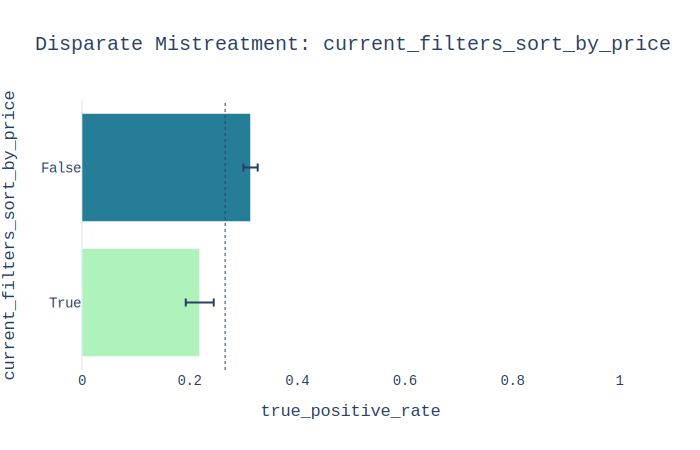

In [7]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [8]:
df_metrics.head()

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
True,current_filters_sort_by_price.1.0,current_filters_sort_by_price,1018,1303,0.218856,0.026016
False,current_filters_sort_by_price.0.0,current_filters_sort_by_price,3013,11115,0.313278,0.013276


In [9]:
df_total.head()

,total_class,total_individuals
sub,,
True,1018 (25.25 %),1303 (10.49 %)
False,3013 (74.75 %),11115 (89.51 %)
total,4031,12418


### current_filters_sort_by_price

In [10]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'city_idx'
input_metrics     = 'true_positive_rate'

In [11]:
sub_map = {'0': "Boston, USA",
            '1': "Como, Italy",
            '2': "Chicago, USA",
            '3': "Lausanne, Switzerland",
            '4': "Dublin, Ireland",
            '5': "Rio de Janeiro, Brazil",
            '6': "Barcelona, Spain",
            '7': "Copenhagen, Denmark",
            '8': "Vienna, Austria",
            '9': "New York, USA",
            '10': "Hong Kong, Hong Kong",
            '11': "Vancouver, Canada"}



fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

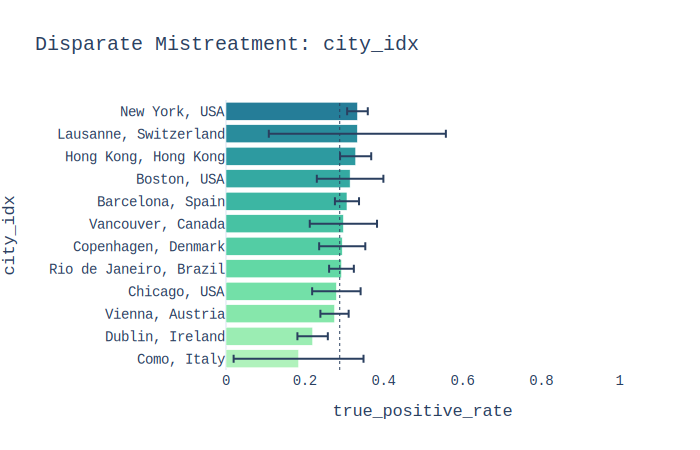

In [12]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [13]:
df_metrics.head(50)

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
"Como, Italy",city_idx.1,city_idx,28,30,0.184211,0.164835
"Dublin, Ireland",city_idx.4,city_idx,270,1035,0.219852,0.038611
"Vienna, Austria",city_idx.8,city_idx,361,1282,0.275460,0.035869
"Chicago, USA",city_idx.2,city_idx,146,375,0.280169,0.061477
"Rio de Janeiro, Brazil",city_idx.5,city_idx,572,2114,0.293080,0.031405
"Copenhagen, Denmark",city_idx.7,city_idx,120,572,0.294983,0.058567
"Vancouver, Canada",city_idx.11,city_idx,83,214,0.297954,0.085353
"Barcelona, Spain",city_idx.6,city_idx,624,1652,0.307026,0.030600
"Boston, USA",city_idx.0,city_idx,97,198,0.314981,0.084484


In [14]:
df_total.head()

,total_class,total_individuals
sub,,
"Como, Italy",28 (0.84 %),30 (0.24 %)
"Dublin, Ireland",270 (8.14 %),1035 (8.33 %)
"Vienna, Austria",361 (10.88 %),1282 (10.32 %)
"Chicago, USA",146 (4.40 %),375 (3.02 %)
"Rio de Janeiro, Brazil",572 (17.24 %),2114 (17.02 %)


### popularity_BIN

In [15]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'price_BIN'
input_metrics     = 'true_positive_rate'

In [16]:
sub_map = {"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"}



fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

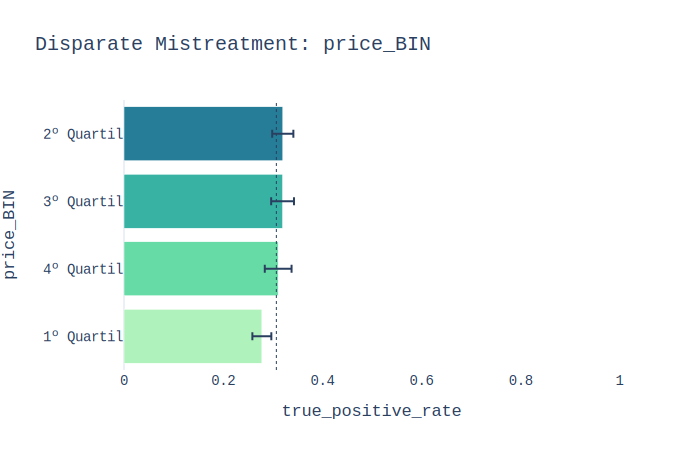

In [17]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [18]:
df_metrics.head(50)

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
1º Quartil,price_BIN.0.0,price_BIN,1788,4235,0.277941,0.019103
4º Quartil,price_BIN.3.0,price_BIN,965,2092,0.310830,0.026984
3º Quartil,price_BIN.2.0,price_BIN,1354,2874,0.319707,0.023004
2º Quartil,price_BIN.1.0,price_BIN,1578,3217,0.320137,0.021326


In [19]:
df_total.head()

,total_class,total_individuals
sub,,
1º Quartil,1788 (31.45 %),4235 (34.10 %)
4º Quartil,965 (16.97 %),2092 (16.85 %)
3º Quartil,1354 (23.82 %),2874 (23.14 %)
2º Quartil,1578 (27.76 %),3217 (25.91 %)
total,5685,12418


### All

In [20]:
df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    sub_map = None
    print(input_features)
    fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = sub_map)    
    #fig.show(renderer="svg")
    fig.write_image("output/tmp/metrics/recsys_fairnes_mistreatment_{}.png".format(input_features.replace("/", "")))    

city_idx
current_filters_1_star
current_filters_2_star
current_filters_3_star
current_filters_4_star
current_filters_5_star
current_filters_air_conditioning
current_filters_airport_shuttle
current_filters_all_inclusive_(upon_inquiry)
current_filters_balcony
current_filters_bathtub
current_filters_beach
current_filters_bed_&_breakfast
current_filters_best_value
current_filters_breakfast_included
current_filters_car_park
current_filters_cheap
current_filters_excellent_rating
current_filters_focus_on_distance
current_filters_focus_on_rating
current_filters_free_wifi_(combined)
current_filters_free_wifi_(rooms)
current_filters_good_rating
current_filters_guest_house
current_filters_hostal_(es)
current_filters_hostel
current_filters_hotel
current_filters_hotel_chain
current_filters_house_/_apartment
current_filters_jacuzzi_(hotel)
current_filters_kitchen
current_filters_luxury_hotel
current_filters_motel
current_filters_non-smoking_rooms
current_filters_pet_friendly
current_filters_pousada_

## Disparate treatment

In [40]:
def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'



    
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index#[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    df    = df.groupby(["action", metric]).agg(
              rewards=("rewards", 'count'),
              metric=(score, 'mean'),
              confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

    df    = df[df.rewards > min_count] # filter min interactions
    #df    = df[df.action.isin(items)]

    #------------------
    df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()
    df_all   = df_group[df_group[metric] >= 3]['action'].values    

    df       = df[df.action.isin(df_all)].iloc[0:int(3*10)]
    
    
    df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
    df3['diff'] = df3['metric_max'] - df3['metric_min']

    df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
    #df_all


    #df    = df[:int(5 * 3)]
    
    for group, rows in df.groupby(metric):
        data.append(go.Bar(name=legend[str(group)], 
                            x=["Item"+":"+str(a) for a in rows["action"]], 
                            y=rows['metric'],
                            error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        xref='paper', x0= 0, x1= 1,
        yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
      )
    ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig

In [41]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



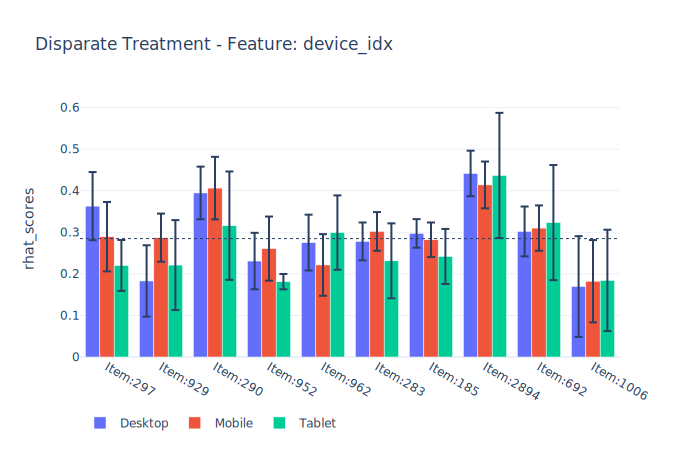

In [42]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

### Image 2

In [ ]:
input_features    = 'popularity_BIN'

In [ ]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"})


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

## Disparate Treatment

In [43]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

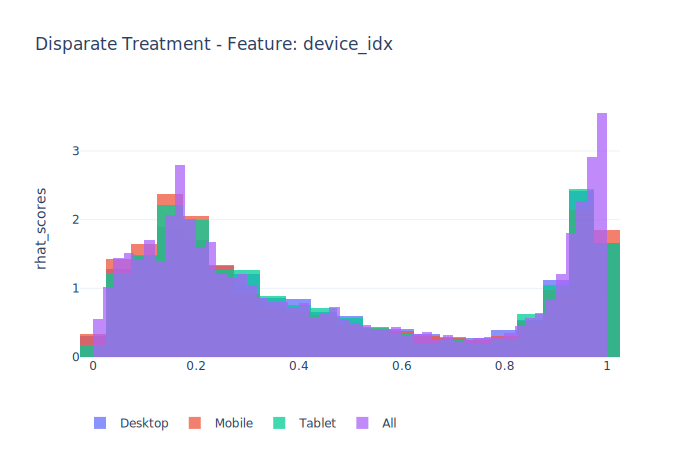

In [67]:
def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]


    for group, rows in df.groupby(metric):
        data.append(go.Histogram(name=legend[str(group)],
                                x=rows[score], 
                                histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
        
    
    data.append(go.Histogram(name="All",
                            x=df[score], 
                            histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]
    
            
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

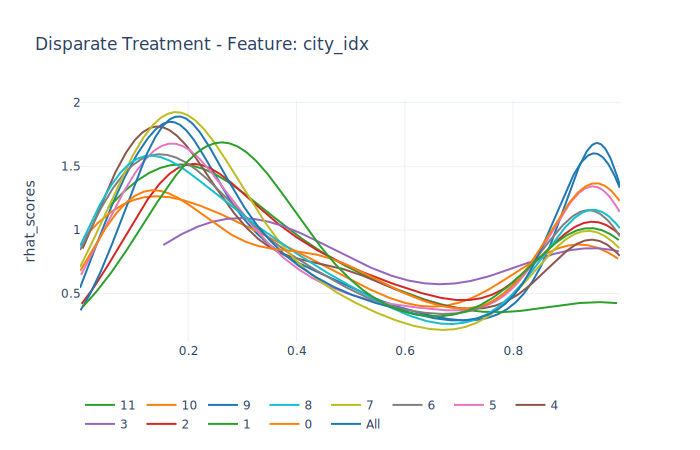

In [80]:
import plotly.figure_factory as ff

def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]
    group_labels = []
    
    data.append(df[score])
    group_labels.append("All")   
    
    for group, rows in df.groupby(metric):
        group_labels.append(str(group))
        data.append(rows[score]) 

        i += 1
  
            
    fig = ff.create_distplot(data, group_labels, show_rug=False, show_hist=False)
        
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    #fig.update_layout(barmode='overlay')
    #fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

city_idx


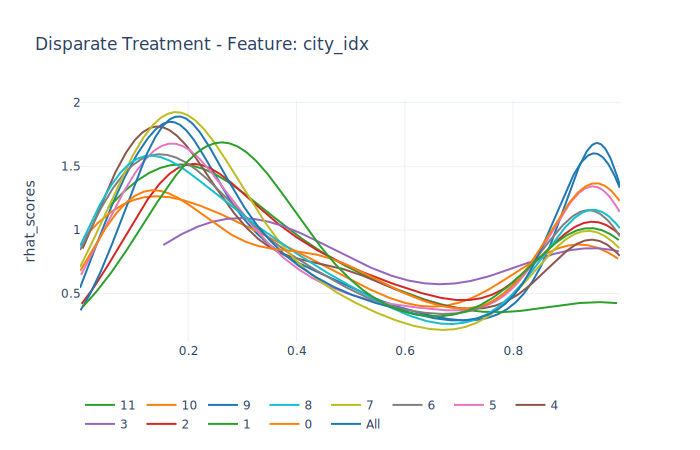

current_filters_1_star


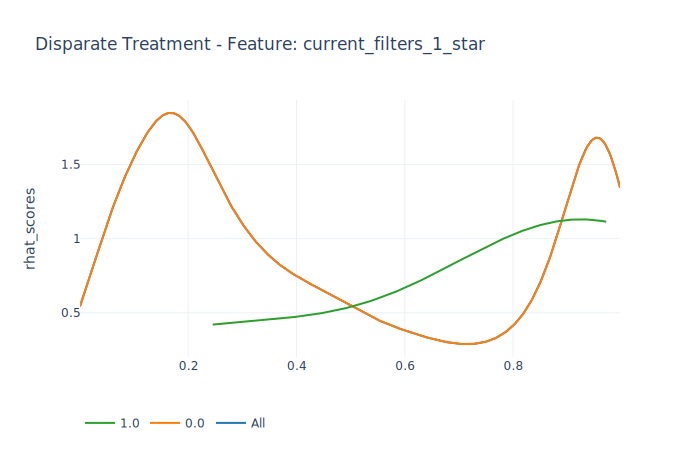

current_filters_2_star


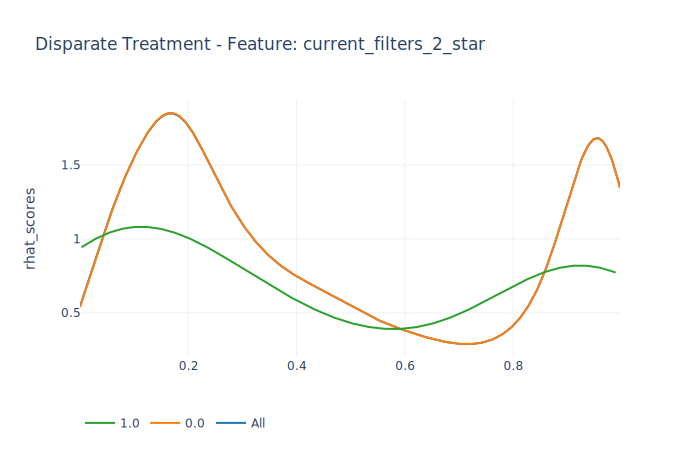

current_filters_3_star


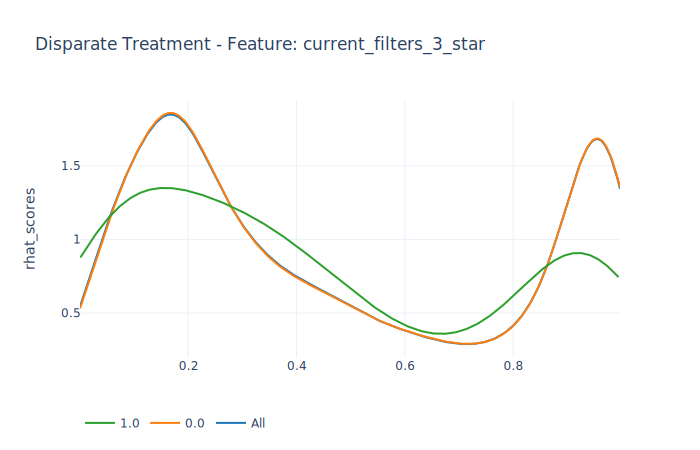

current_filters_4_star


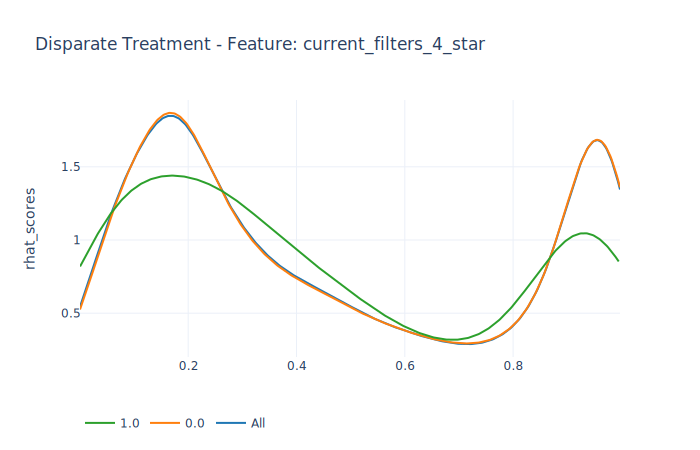

current_filters_5_star


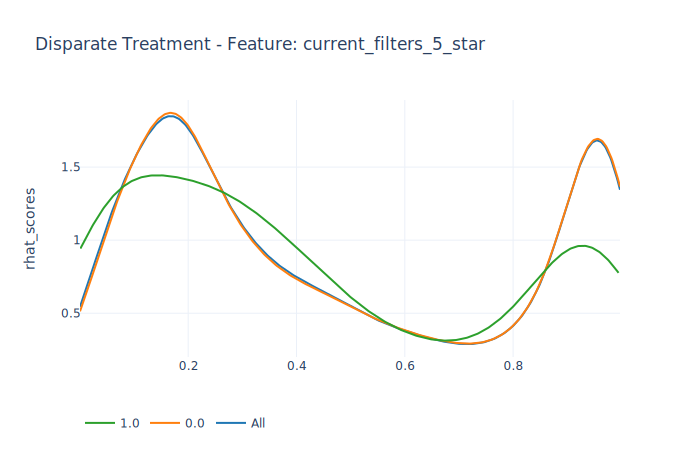

current_filters_air_conditioning


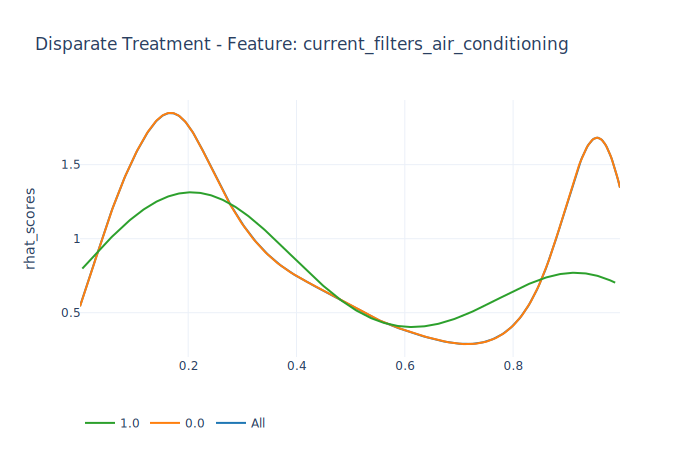

current_filters_airport_shuttle


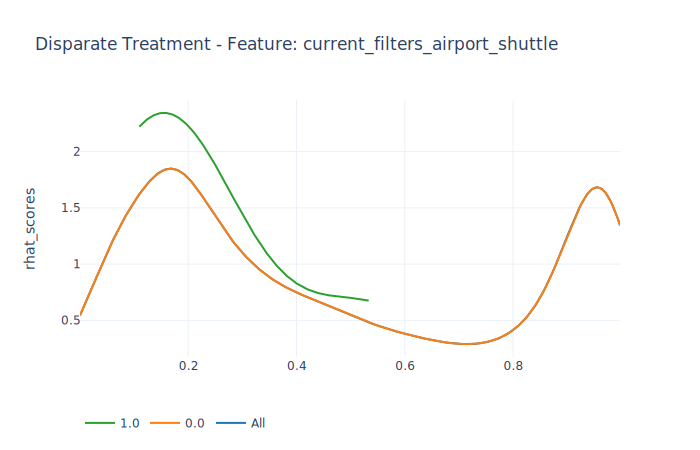

current_filters_all_inclusive_(upon_inquiry)


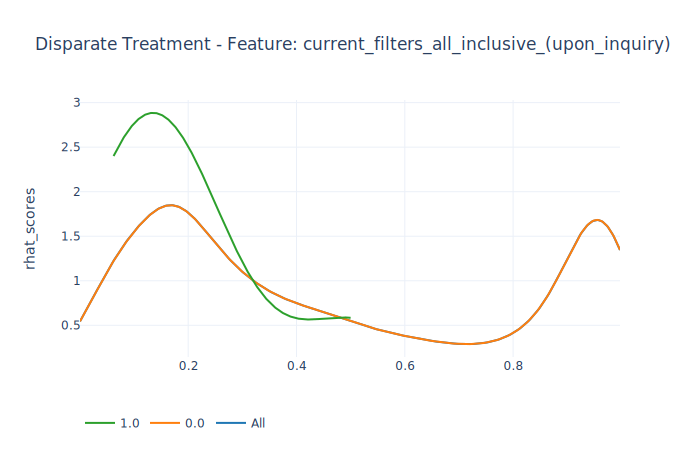

current_filters_balcony


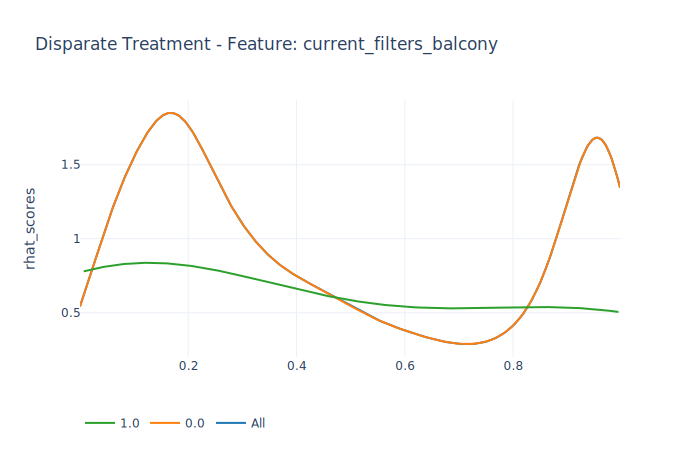

current_filters_bathtub


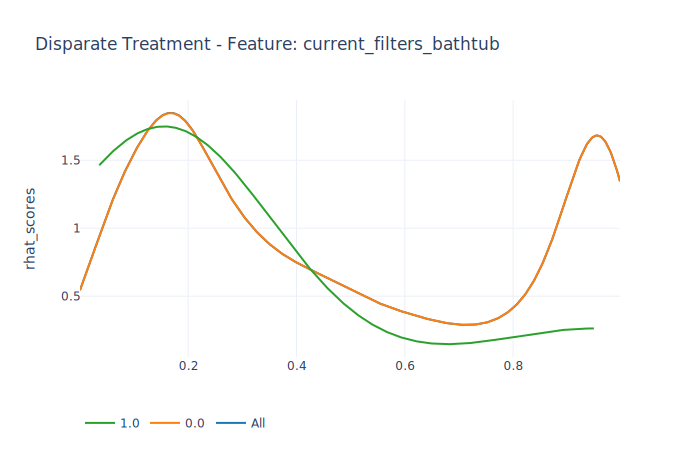

current_filters_beach


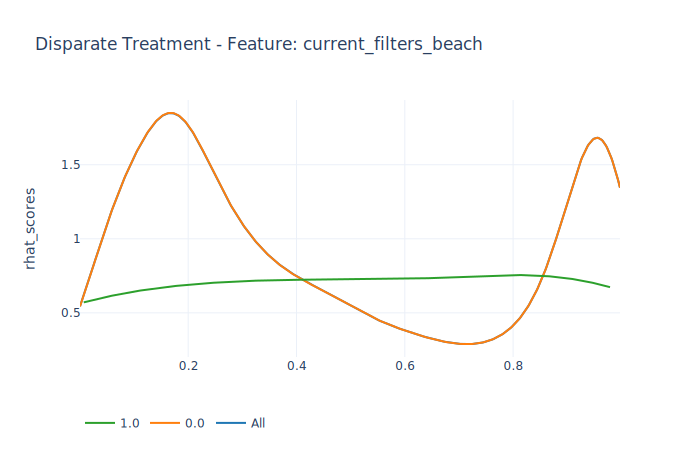

current_filters_bed_&_breakfast


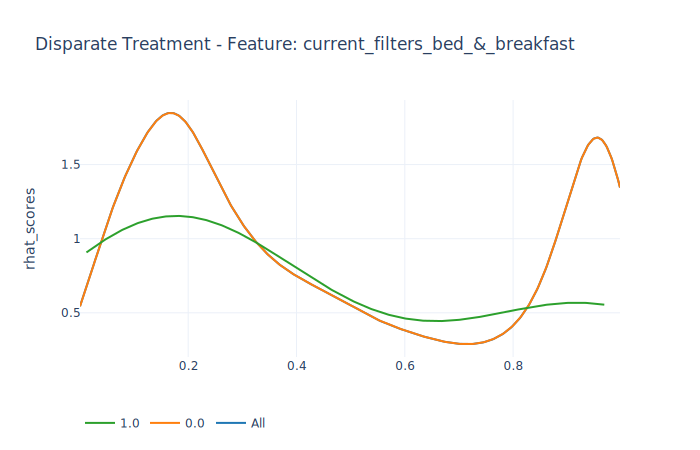

current_filters_best_value


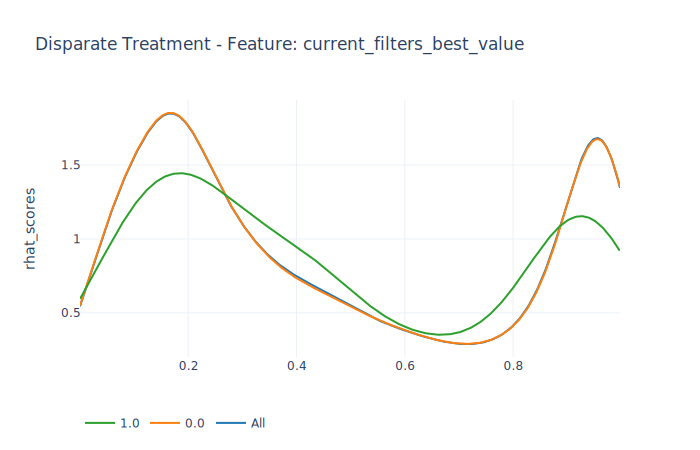

current_filters_breakfast_included


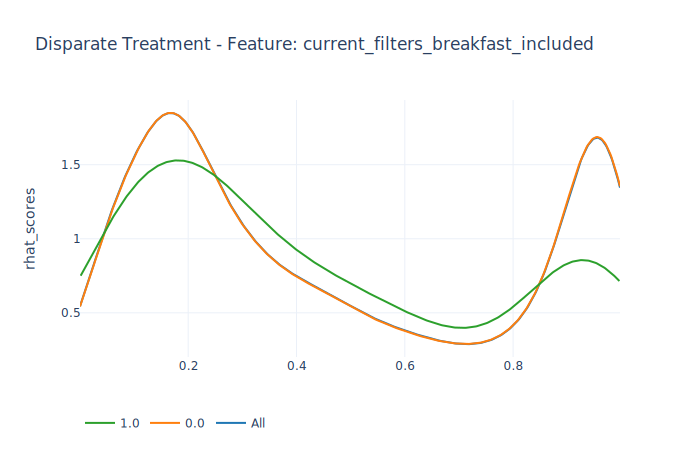

current_filters_car_park


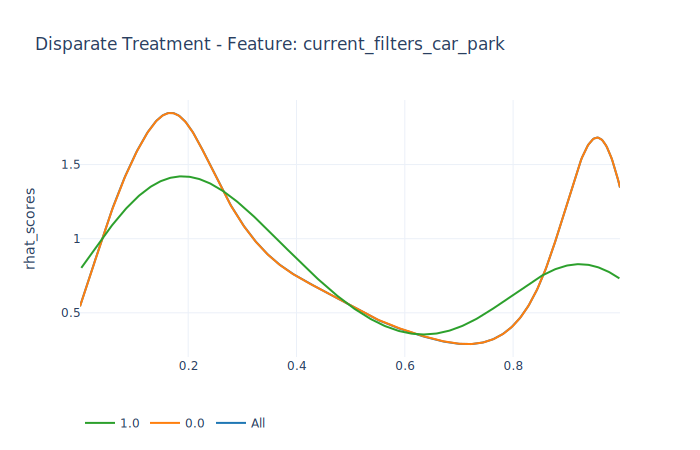

current_filters_cheap


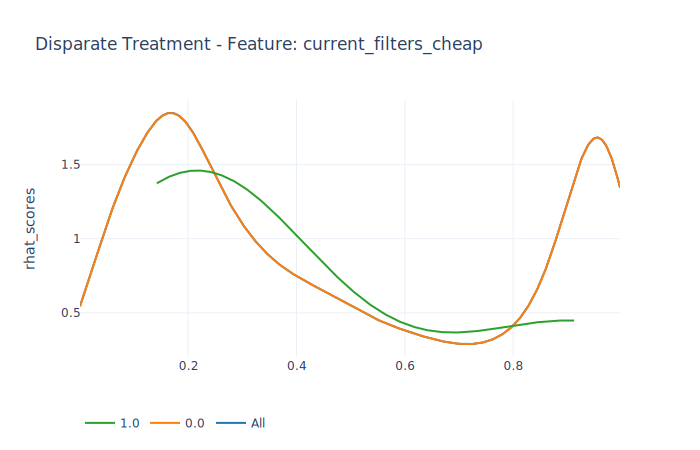

current_filters_excellent_rating


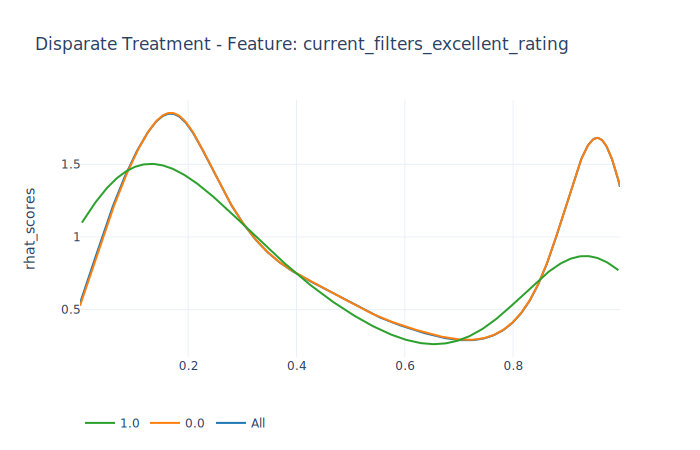

current_filters_focus_on_distance


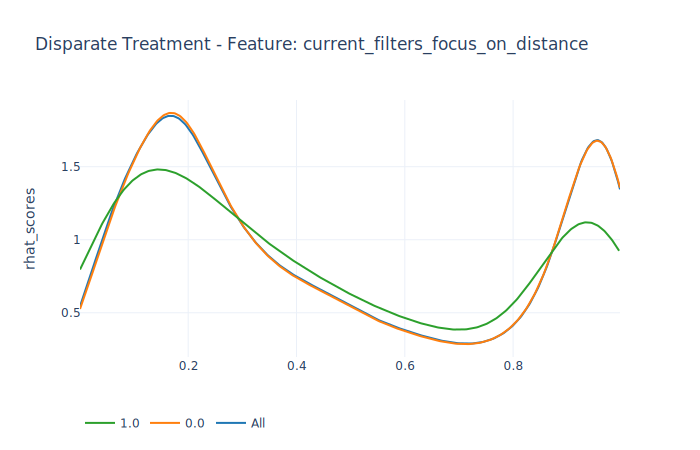

current_filters_focus_on_rating


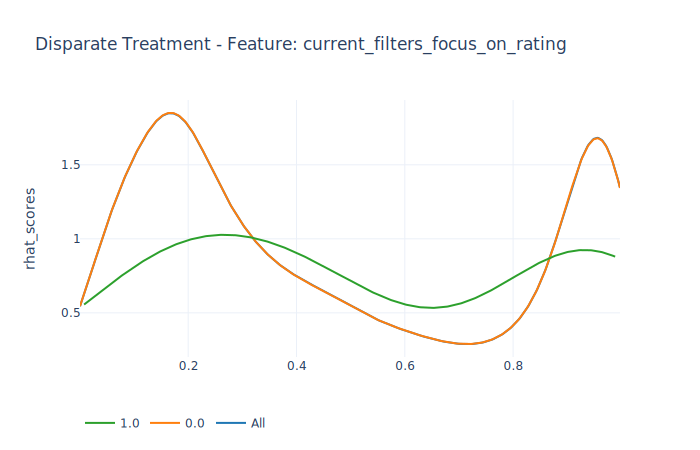

current_filters_free_wifi_(combined)


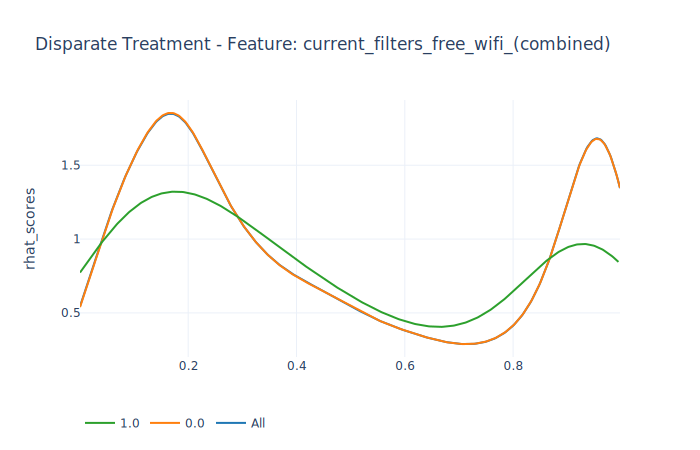

current_filters_free_wifi_(rooms)


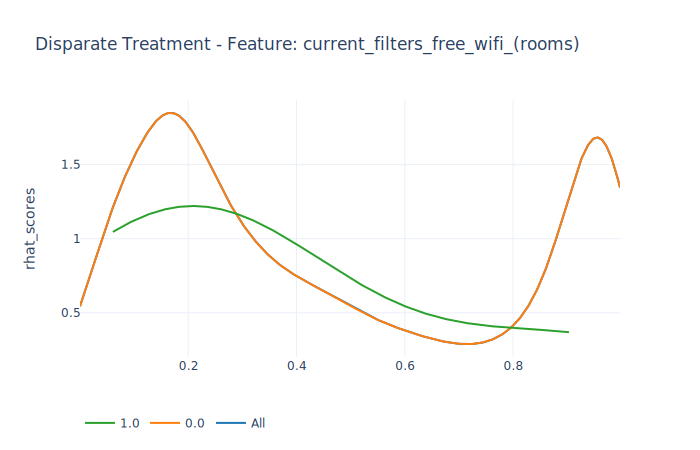

current_filters_good_rating


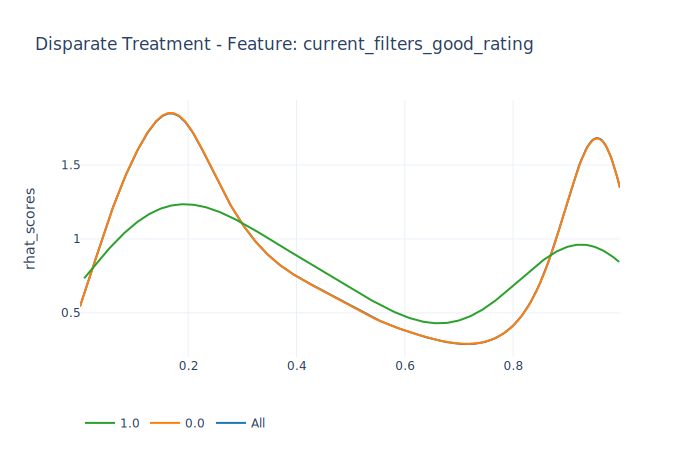

current_filters_guest_house


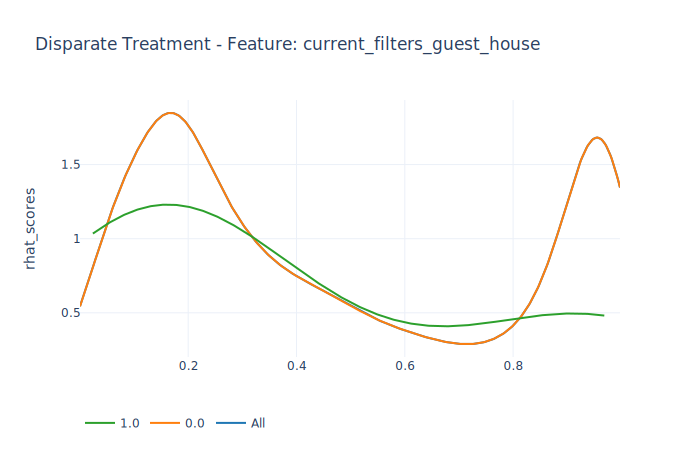

current_filters_hostal_(es)


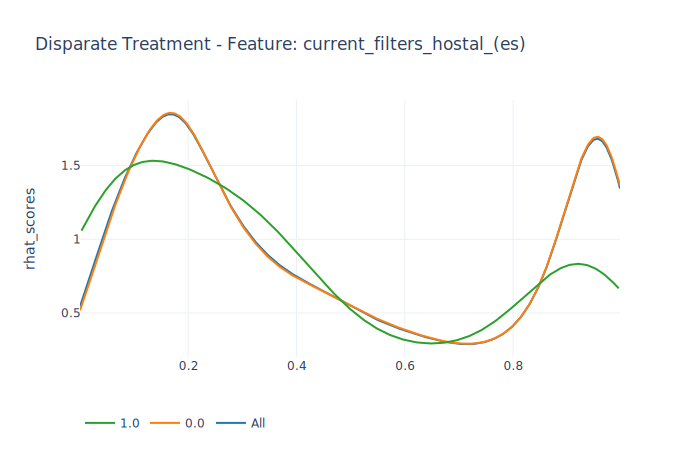

current_filters_hostel


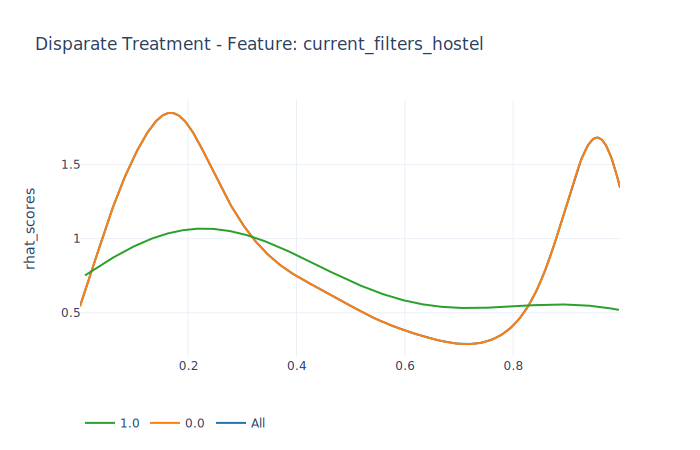

current_filters_hotel


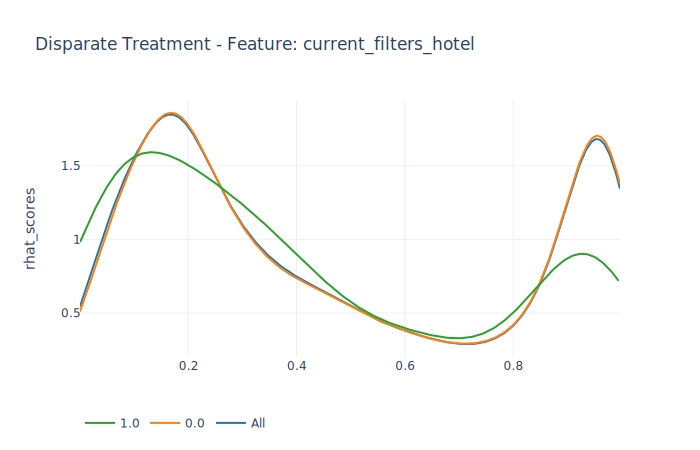

current_filters_hotel_chain


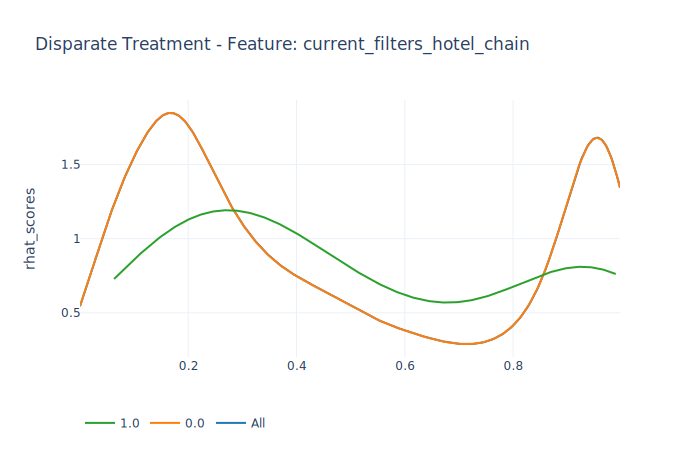

current_filters_house_/_apartment


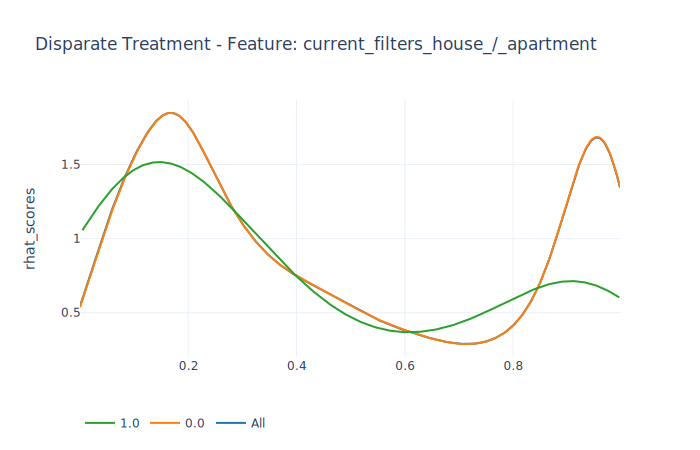

current_filters_jacuzzi_(hotel)


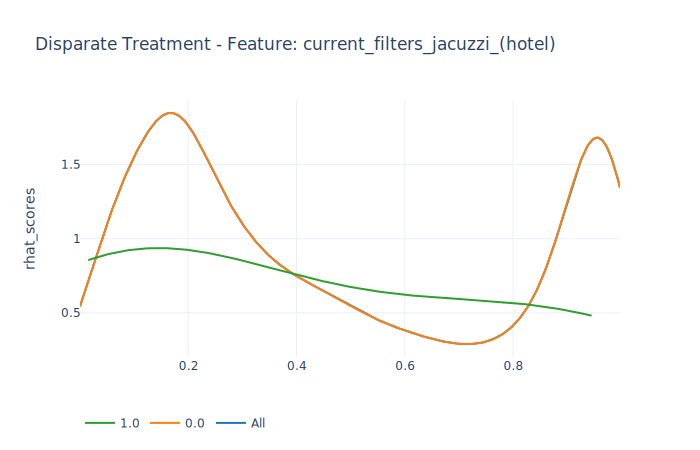

current_filters_kitchen


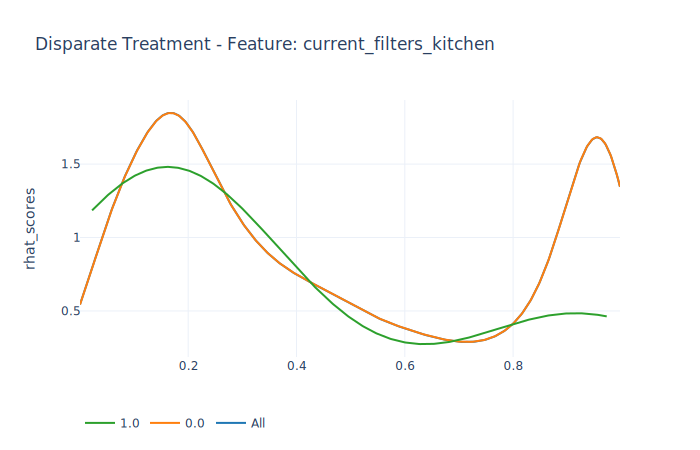

current_filters_luxury_hotel


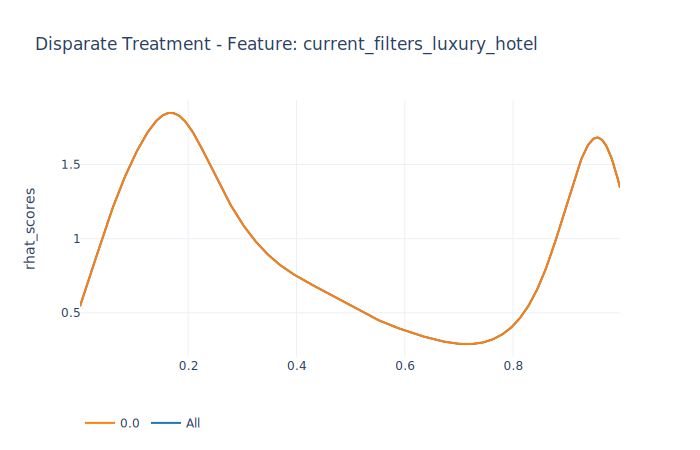

current_filters_motel


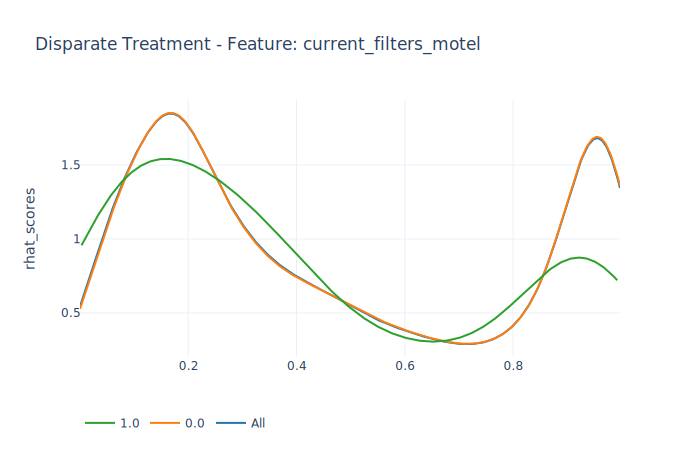

current_filters_non-smoking_rooms


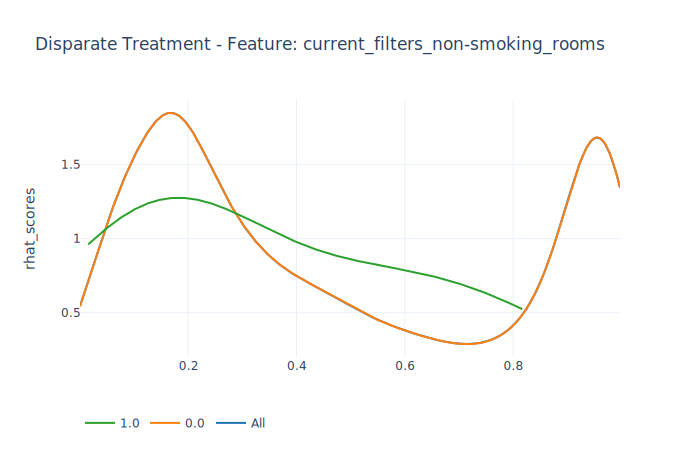

current_filters_pet_friendly


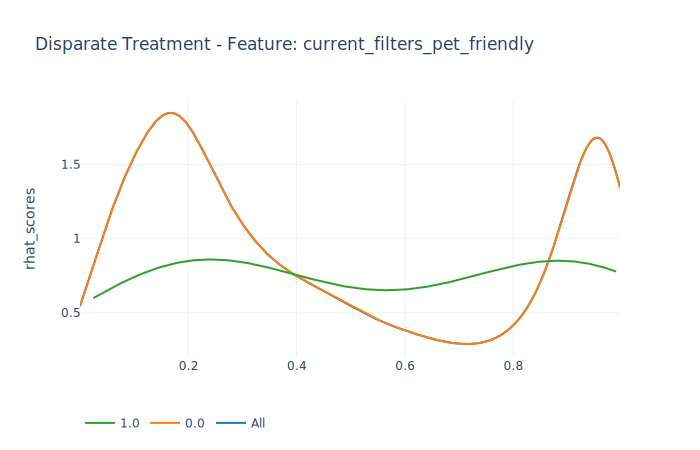

current_filters_pousada_(br)


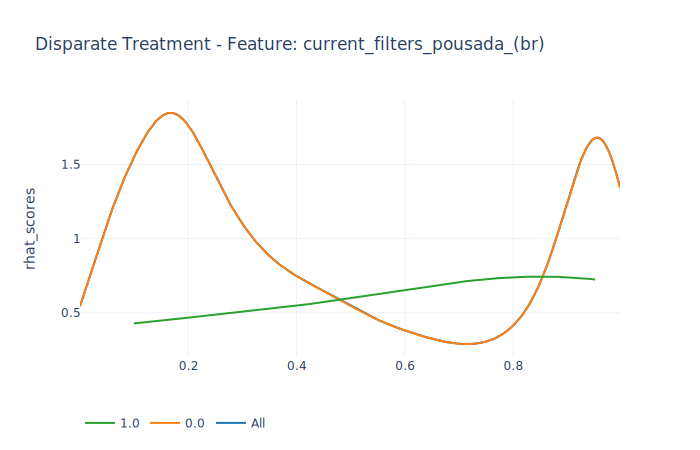

current_filters_reception_(24/7)


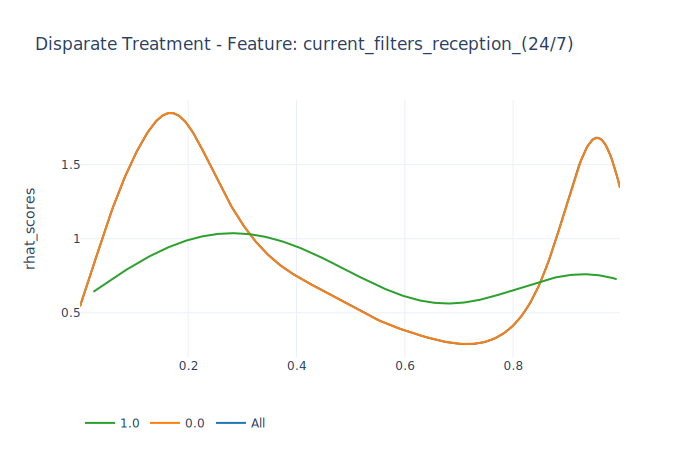

current_filters_resort


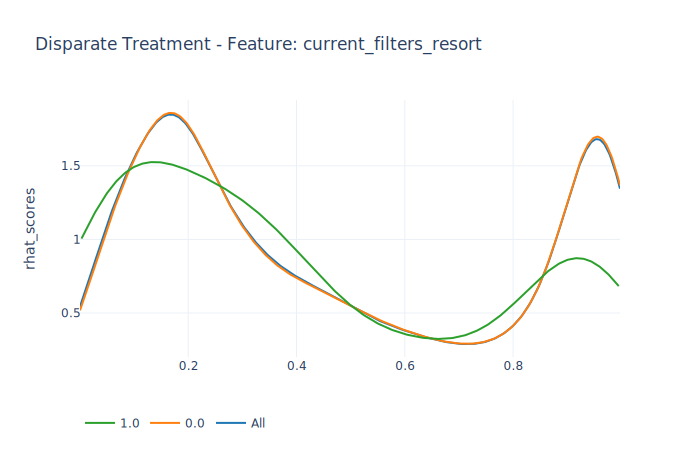

current_filters_restaurant


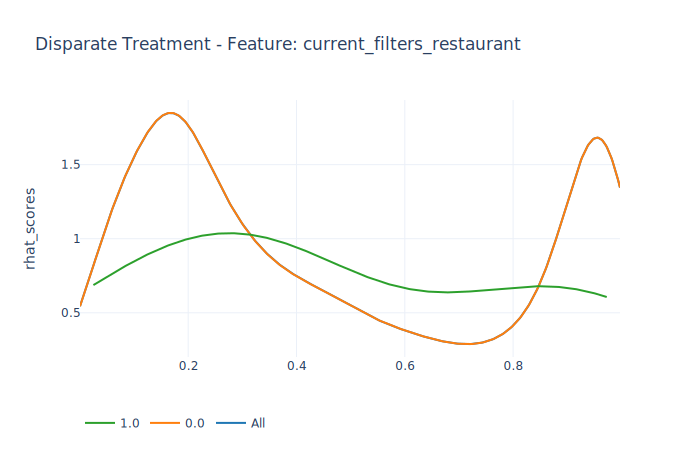

current_filters_satisfactory_rating


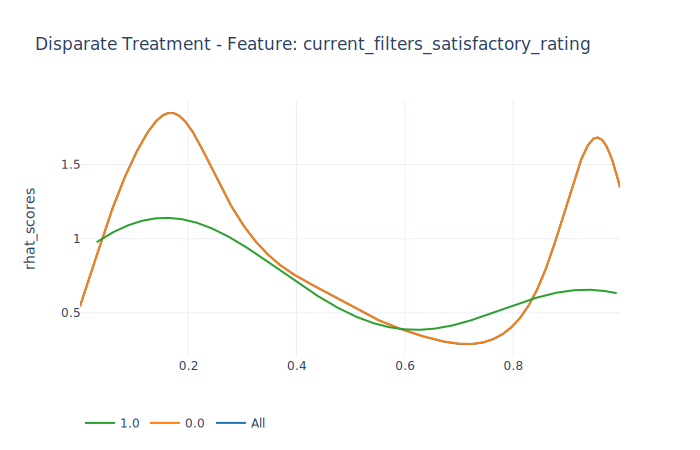

current_filters_serviced_apartment


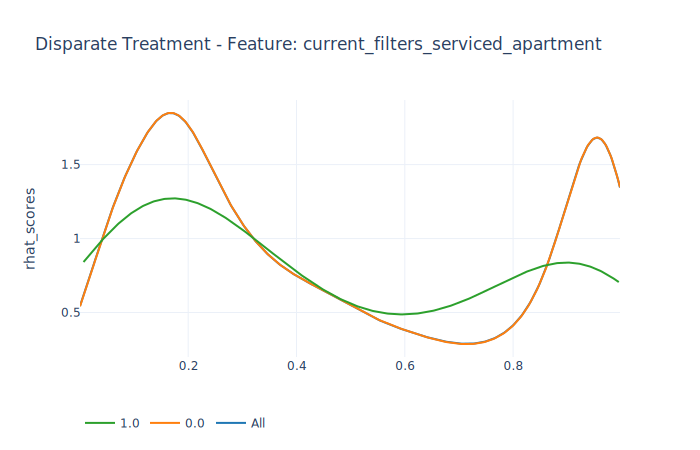

current_filters_sort_by_distance


KeyboardInterrupt: 

In [81]:
df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    print(input_features)
    
    fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                                      title="Disparate Treatment - Feature: "+input_features)

    fig.show(renderer="svg")

    fig.write_image("output/tmp/metrics/recsys_fairnes_Treatment_{}.png".format(input_features.replace("/", "")))    